Ensure you have GPU installed: go to Menu > Runtime > Change runtime > Change hardware acceleration to GPU

# Task 1, 2

## Installs

A proper install is half a deal with PaddleOCR!

I have to import libraries in two steps: first for Task 1, 2 and only after that for Task 3. Otherwise I get strange fatal errors during tensor processing like 'CUBLAS_STATUS_NOT_SUPPORTED'

Checking that we've got GPU installed on Google Colab VM


In [1]:
!nvidia-smi

Mon Feb  6 20:15:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    53W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Check version of NVIDIA Cuda compiler driver. It should match PaddleOCR library package

In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


We should install paddlepaddle-gpu package matching installed NVIDIA Cuda compiler driver. Choose your version on [https://www.paddlepaddle.org.cn/](https://www.paddlepaddle.org.cn/)

In my case I have Cuda compiler driver version 11.2, so I should install paddlepaddle-gpu with this command `python -m pip install paddlepaddle-gpu==2.4.1.post112 -f https://www.paddlepaddle.org.cn/whl/linux/mkl/avx/stable.html`

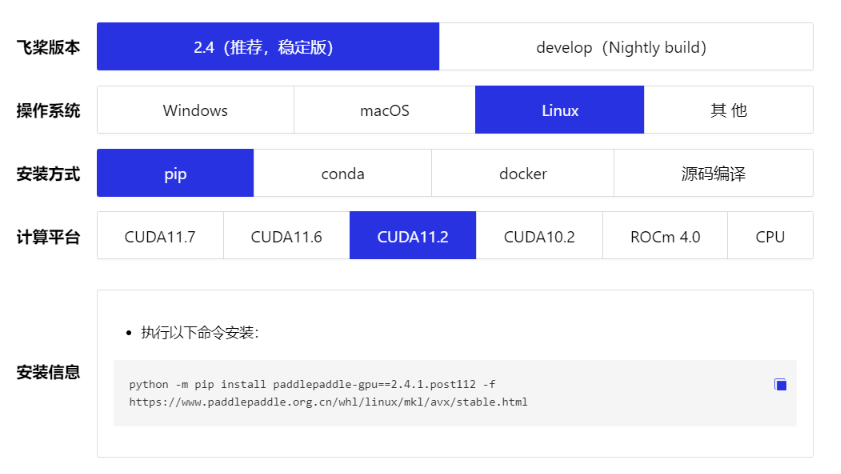

In [ ]:
!python -m pip install paddlepaddle-gpu==2.4.1.post112 -f https://www.paddlepaddle.org.cn/whl/linux/mkl/avx/stable.html

Check installed version. It should match version from previous step

In [4]:
!python -c "import paddle; print(paddle.__version__)"

2.4.1


Install PaddleOCR

In [ ]:
!pip install "paddleocr>=2.0.1" --quiet
!pip install transformers --quiet

Install package for metrics. Levenshtein distance is widely used for OCR tasks. More info [here](https://en.wikipedia.org/wiki/Levenshtein_distance)

In [ ]:
!pip install Levenshtein --quiet

Clone repo with train/test data from ICDAR2019 SROIE competition

In [7]:
!git clone https://github.com/recycletechno/SROIE-dataset.git

Cloning into 'SROIE-dataset'...
remote: Enumerating objects: 3887, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3887 (delta 0), reused 3 (delta 0), pack-reused 3884
Receiving objects: 100% (3887/3887), 426.82 MiB | 27.90 MiB/s, done.
Resolving deltas: 100% (495/495), done.
Updating files: 100% (2921/2921), done.


## Imports

In [8]:
import os
import shutil
from PIL import Image
import json
from tqdm.notebook import tqdm
from paddleocr import PaddleOCR
import requests

## Links

Making service folders and links to it

In [9]:
sroie_root_dir = './SROIE-dataset/'

In [10]:
os.mkdir(os.path.join(sroie_root_dir, 'test_predicted'))
os.mkdir(os.path.join(sroie_root_dir, 'test_predicted/box/'))
os.mkdir(os.path.join(sroie_root_dir, 'test_predicted/entities/'))
os.mkdir(os.path.join(sroie_root_dir, 'compare'))
os.mkdir(os.path.join(sroie_root_dir, 'downloads'))
os.mkdir(os.path.join(sroie_root_dir, 'downloads/box/'))
os.mkdir(os.path.join(sroie_root_dir, 'downloads/entities/'))
os.mkdir(os.path.join(sroie_root_dir, 'downloads/origs/'))

In [11]:
sroie_test_img_dir = os.path.join(sroie_root_dir, 'test/img')
sroie_test_box_dir = os.path.join(sroie_root_dir, 'test/box')
sroie_test_pred_ent_dir = os.path.join(sroie_root_dir, 'test_predicted/entities')
sroie_test_pred_box_dir = os.path.join(sroie_root_dir, 'test_predicted/box')
sroie_test_gt_ent_dir = os.path.join(sroie_root_dir, 'test/entities')
sroie_compare_dir = os.path.join(sroie_root_dir, 'compare')

Helper function to clear directory contents

In [12]:
def clear_dir_files(some_dir):
    for fn in os.listdir(some_dir):
        if fn != '.ipynb_checkpoints':
            os.remove(f'{some_dir}/{fn}')

## Process images

On this step we load default models for text detection and recognition. You can use any other model e.g. from this [link](https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.6/doc/doc_en/models_list_en.md)

In my case (as of 05 Feb 2023) models were:

*   PP-OCRv3/english/en_PP-OCRv3_det_infer.tar as a detection model
*   PP-OCRv3/english/en_PP-OCRv3_rec_infer.tar as a recognition model

Did not use text angle classification model as receipts are not rotated in general and it gives better performance

In [13]:
ocr = PaddleOCR(
    rec_model_dir='https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_rec_infer.tar',
    det_model_dir='https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_det_infer.tar',
    use_angle_cls=False,
    lang='en', 
    use_gpu=True
    )

download https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_det_infer.tar to /root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer/en_PP-OCRv3_det_infer.tar


100%|██████████| 4.00M/4.00M [00:16<00:00, 236kiB/s] 


download https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_rec_infer.tar to /root/.paddleocr/whl/rec/en/en_PP-OCRv3_rec_infer/en_PP-OCRv3_rec_infer.tar


100%|██████████| 9.96M/9.96M [00:18<00:00, 527kiB/s] 


download https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar to /root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer/ch_ppocr_mobile_v2.0_cls_infer.tar


100%|██████████| 2.19M/2.19M [00:09<00:00, 233kiB/s]

[2023/02/06 20:19:53] ppocr DEBUG: Namespace(alpha=1.0, benchmark=False, beta=1.0, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgnet_mode='fast', e2e_pgnet_score_thresh=0.5, e2e_pgnet_valid_set

Function to make a file with vertices and recognized text (output requirements tasks 1,2)

In [14]:
def make_box_file(img_dir, output_dir, file_name):

    result = ocr.ocr(f'{img_dir}/{file_name}', cls=True)
    file_name_2 = file_name.split('.')[0] + '.txt'

    with open(f'{output_dir}/{file_name_2}', "w") as file:
        for i in range(len(result)):
            res = result[i]

            for line in res:
                data = []

                for j in range(len(line[0])):
                    coords = line[0][j]

                    data.append(str(int(coords[0])))
                    data.append(str(int(coords[1])))

                data.append(str(line[1][0]).upper())
                file.write((',').join(data) + '\n')

Let's try it on any random picture from test folder

In [15]:
res = ocr.ocr(f'{sroie_test_img_dir}/X51005268408.jpg', cls=False)

for x in res[0]:
    print(x)

[2023/02/06 20:20:01] ppocr DEBUG: dt_boxes num : 39, elapse : 4.924583196640015
[2023/02/06 20:20:03] ppocr DEBUG: rec_res num  : 39, elapse : 2.077375650405884
[[[140.0, 283.0], [538.0, 279.0], [539.0, 312.0], [141.0, 315.0]], ('99 SPEEO MA8T 5/8 519537-X)', 0.8511126637458801)]
[[[153.0, 320.0], [540.0, 317.0], [540.0, 351.0], [153.0, 354.0]], ('LOT P..2811. JALAN ANGSA.', 0.8750860095024109)]
[[[241.0, 359.0], [447.0, 355.0], [447.0, 388.0], [242.0, 392.0]], ('TAMAN BERKELEY', 0.9668185114860535)]
[[[202.0, 401.0], [505.0, 394.0], [506.0, 427.0], [203.0, 434.0]], ('41150 KLANG.SELANGOR', 0.8844811320304871)]
[[[232.0, 440.0], [477.0, 435.0], [477.0, 464.0], [232.0, 470.0]], ('1413-SETIA ALAM 2', 0.8578541278839111)]
[[[177.0, 481.0], [536.0, 471.0], [537.0, 503.0], [177.0, 513.0]], ('GS7 ID.NO 800181757712', 0.8252810835838318)]
[[[165.0, 561.0], [563.0, 547.0], [564.0, 579.0], [167.0, 593.0]], ('INV0ICE NO : 18222/102/T0341', 0.8557521104812622)]
[[[536.0, 624.0], [655.0, 616.0], 

Clear folder after first try

In [16]:
clear_dir_files(sroie_test_pred_box_dir)

Run `make_box_file` on all pictures in test folder

In [ ]:
for file_name in tqdm(os.listdir(sroie_test_img_dir)):
    make_box_file(
        img_dir = sroie_test_img_dir,
        output_dir = sroie_test_pred_box_dir,
        file_name = file_name
        )

print('Done')

## Test metrics

In [18]:
from Levenshtein import ratio as Levenshtein_ratio
import json
import pandas as pd
import os

iou_thr = 0.6
lratio_thr = 0.6

def calculate_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[0] + box1[2], box2[0] + box2[2])
    y2 = min(box1[1] + box1[3], box2[1] + box2[3])

    interArea = max(0, x2 - x1) * max(0, y2 - y1)

    box1Area = box1[2] * box1[3]
    box2Area = box2[2] * box2[3]

    iou = interArea / float(max(1, box1Area + box2Area - interArea))
    return iou

def calculate_AP(gt: pd.DataFrame, pred: pd.DataFrame, iou_thr, Lratio_thr, case_sensitive=False):

    detection_pairs = list()

    gt_boxes = gt[['x', 'y', 'w', 'h']].astype(int).to_numpy().tolist()
    gt_texts = gt['text'].to_numpy().tolist()

    pred_boxes = pred[['x', 'y', 'w', 'h']].astype(int).to_numpy().tolist()
    pred_texts = pred['text'].to_numpy().tolist()

    for i, gt_box in enumerate(gt_boxes):
        best_iou = 0
        best_pred_text = None

        for j, pred_box in enumerate(pred_boxes):
            iou = calculate_iou(gt_box, pred_box)

            if iou > best_iou:
                best_iou = iou
                best_pred_text = pred_texts[j]

        if best_iou > 0:
            gt_text = gt_texts[i]

            if case_sensitive:
                ratio = Levenshtein_ratio(gt_text, best_pred_text)
            else:
                ratio = Levenshtein_ratio(gt_text.lower(), best_pred_text.lower())

            detection_pairs.append((best_iou, ratio))

    TP = 0
    FP = 0

    for iou, ratio in detection_pairs:
        if iou < iou_thr or ratio < Lratio_thr:
            FP += 1
        else:
            TP += 1

    return (TP / max(1, TP + FP), sum(iou for iou, _ in detection_pairs) / len(detection_pairs),
            sum(ratio for _, ratio in detection_pairs) / len(detection_pairs))

def calculate_mean_Levenshtein_similarity(gt: dict, pred: dict, case_sensitive=False):
    assert len(gt) == len(pred)
    assert set(gt.keys()) == set(pred.keys())

    gt = [v for k, v in sorted(gt.items(), key=lambda item: item[0])]
    pred = [v for k, v in sorted(pred.items(), key=lambda item: item[0])]

    if case_sensitive:
        return sum([Levenshtein_ratio(gt_str, pred_str) for gt_str, pred_str in zip(gt, pred)]) / len(gt)
    else:
        return sum([Levenshtein_ratio(gt_str.lower(), pred_str.lower()) for gt_str, pred_str in zip(gt, pred)]) / len(gt)

def calc_metric_for_dir(gt_path_dir, pred_path_dir):
    APs = list()
    IOUs = list()
    MRs = list()

    for fn in os.listdir(os.path.join(gt_path_dir)):

        with open(os.path.join(gt_path_dir, fn), 'r') as f:

            lines = [l.strip().split(',') for l in f.readlines()]

            lines = [l[:8] + [','.join(l[8:])] for l in lines]

            gt_box_df = pd.DataFrame(data=lines, columns=['x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4', 'text'])

            gt_box_df['x'] = gt_box_df['x1'].astype(int)
            gt_box_df['y'] = gt_box_df['y1'].astype(int)
            gt_box_df['w'] = gt_box_df['x2'].astype(int) - gt_box_df['x1'].astype(int)
            gt_box_df['h'] = gt_box_df['y3'].astype(int) - gt_box_df['y1'].astype(int)

            gt_box_df = gt_box_df.drop(columns=['x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4'])

        with open(os.path.join(pred_path_dir, fn)) as f:
            lines = [l.strip().split(',') for l in f.readlines()]

            lines = [l[:8] + [','.join(l[8:])] for l in lines]

            pred_box_df = pd.DataFrame(data=lines, columns=['x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4', 'text'])

            pred_box_df['x'] = pred_box_df['x1'].astype(int)
            pred_box_df['y'] = pred_box_df['y1'].astype(int)
            pred_box_df['w'] = pred_box_df['x2'].astype(int) - pred_box_df['x1'].astype(int)
            pred_box_df['h'] = pred_box_df['y3'].astype(int) - pred_box_df['y1'].astype(int)

            pred_box_df = pred_box_df.drop(columns=['x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4'])

        ap, mean_iou, mean_ratio = calculate_AP(gt_box_df, pred_box_df, iou_thr, lratio_thr)
        APs.append(ap)
        IOUs.append(mean_iou)
        MRs.append(mean_ratio)

    return round(sum(APs)/len(APs), 4), round(sum(IOUs)/len(IOUs), 4), round(sum(MRs)/len(MRs), 4)

def calc_metric_for_file(gt_path_dir, pred_path_dir, fn):

    with open(os.path.join(gt_path_dir, fn), 'r') as f:

        lines = [l.strip().split(',') for l in f.readlines()]

        lines = [l[:8] + [','.join(l[8:])] for l in lines]

        gt_box_df = pd.DataFrame(data=lines, columns=['x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4', 'text'])

        gt_box_df['x'] = gt_box_df['x1'].astype(int)
        gt_box_df['y'] = gt_box_df['y1'].astype(int)
        gt_box_df['w'] = gt_box_df['x2'].astype(int) - gt_box_df['x1'].astype(int)
        gt_box_df['h'] = gt_box_df['y3'].astype(int) - gt_box_df['y1'].astype(int)

        gt_box_df = gt_box_df.drop(columns=['x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4'])

    with open(os.path.join(pred_path_dir, fn)) as f:
        lines = [l.strip().split(',') for l in f.readlines()]

        lines = [l[:8] + [','.join(l[8:])] for l in lines]

        pred_box_df = pd.DataFrame(data=lines, columns=['x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4', 'text'])

        pred_box_df['x'] = pred_box_df['x1'].astype(int)
        pred_box_df['y'] = pred_box_df['y1'].astype(int)
        pred_box_df['w'] = pred_box_df['x2'].astype(int) - pred_box_df['x1'].astype(int)
        pred_box_df['h'] = pred_box_df['y3'].astype(int) - pred_box_df['y1'].astype(int)

        pred_box_df = pred_box_df.drop(columns=['x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4'])

    ap, mean_iou, mean_ratio = calculate_AP(gt_box_df, pred_box_df, iou_thr, lratio_thr)

    return round(ap, 4), round(mean_iou, 4), round(mean_ratio, 4)

Get metrics for all test folder. We use mean average presicion, intersection over union and mean levenshtein ratio. Feel free to adjust `iou_thr` and `lratio_thr`


In [19]:
result = calc_metric_for_dir(
    gt_path_dir=sroie_test_box_dir,
    pred_path_dir=sroie_test_pred_box_dir
)
print('Mean mAP [{}] IoU [{}] mLr [{}]'.format(*result))

Mean mAP [0.8274] IoU [0.7432] mLr [0.9337]


## Demo on test folder

Function to take random image from test folder and show bounding boxes, verticles and text on this receipt

In [23]:
import cv2
import matplotlib
import numpy as np

def display_gt_and_pred_sroie(fn, rect_boxes=False, show=True, save=True):

    image_path = f'{sroie_test_img_dir}/{fn}'
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    gt_path = f'{sroie_test_box_dir}/{fn[:-4]}.txt'
    pred_path = f'{sroie_test_pred_box_dir}/{fn[:-4]}.txt'

    bboxes_gt = []
    with open(gt_path, 'r') as f:
        for line in f.read().splitlines():
            split_lines = line.split(",")
            bboxes_gt.append(np.array(split_lines[0:8], dtype=np.int32))

    bboxes_pred = []
    with open(pred_path, 'r') as f:
        for line in f.read().splitlines():
            split_lines = line.split(",")
            bboxes_pred.append(np.array(split_lines[0:8], dtype=np.int32))
    
    # Plot gt (green)
    for bbox_gt in bboxes_gt:
        (x1g, y1g, x2g, y2g) = bbox_gt[0], bbox_gt[1], bbox_gt[4], bbox_gt[5] 
        img = cv2.rectangle(img, (x1g, y1g), (x2g, y2g), (0,255,0), 2)

    if rect_boxes:
        # Plot pred (red)
        for bbox_pred in bboxes_pred:
            (x1p, y1p, x2p, y2p) = bbox_pred[0], bbox_pred[1], bbox_pred[4], bbox_pred[5]
            img = cv2.rectangle(img, (x1p, y1p), (x2p, y2p), (255,0,0), 2)
    else:
        # Plot pred (red)
        for bp in bboxes_pred:
            points = np.array([[bp[0], bp[1]], [bp[2], bp[3]], [bp[4], bp[5]], [bp[6], bp[7]]])
            img = cv2.polylines(img, np.int32([points]), 1, (255,0,0), 2)

    if save:
        image_to_write = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        cv2.imwrite(f'{sroie_compare_dir}/{fn}', image_to_write)

    if show:
        matplotlib.rcParams['figure.figsize'] = 15, 18

        fig, ax = matplotlib.pyplot.subplots()
        ax.set_title(fn, fontsize= 30)
        ax.imshow(img);
        matplotlib.pyplot.show()

You can pick any image from test folder - just modify `fn` variable in the code cell below

Red boxes are predictions and green boxes are the ground truths

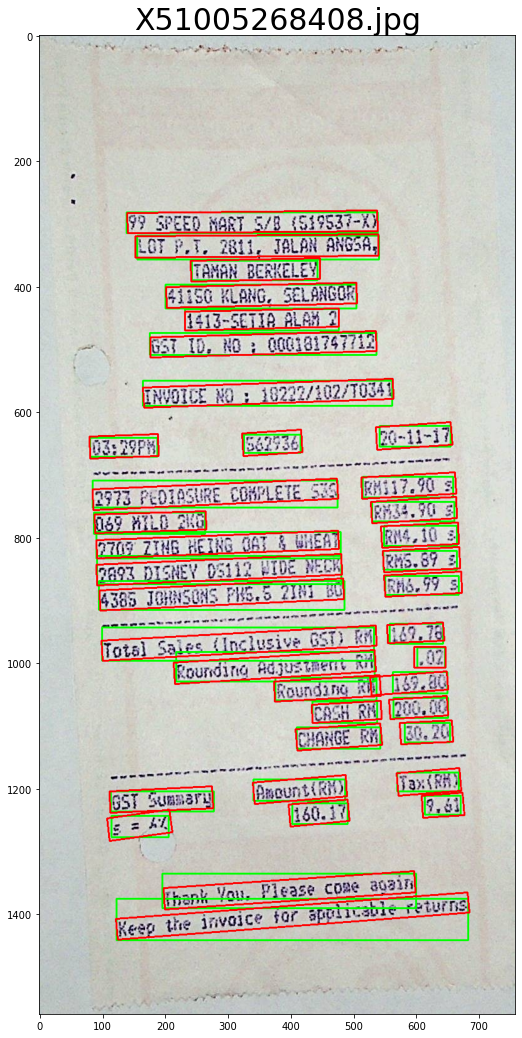

In [24]:
# fn = 'X51005230648.jpg'
fn = 'X51005268408.jpg'

display_gt_and_pred_sroie(
    fn=fn,
    rect_boxes=False,
    show=True, 
    save=False
    )

## Demo on random receipt

A function get the output for task 1,2 and to display detected boxes on any receipt downloaded from internet, just modify `url` variable to analyze different images

In [33]:
def display_boxes_on_file(fn, rect_boxes=False):

    image_path = os.path.join(sroie_root_dir, 'downloads/origs/', fn)

    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    make_box_file(
        os.path.join(sroie_root_dir, 'downloads/origs'), 
        os.path.join(sroie_root_dir, 'downloads/box'), 
        fn
        )
    pred_path = os.path.join(sroie_root_dir, 'downloads/box', fn[:-4] + '.txt')

    bboxes_pred = []
    with open(pred_path, 'r') as f:
        for line in f.read().splitlines():
            split_lines = line.split(",")
            bboxes_pred.append(np.array(split_lines[0:8], dtype=np.int32))
            print(split_lines[:8], ','.join(split_lines[8:]))

    if rect_boxes:
        # Plot pred (red)
        for bbox_pred in bboxes_pred:
            (x1p, y1p, x2p, y2p) = bbox_pred[0], bbox_pred[1], bbox_pred[4], bbox_pred[5]
            img = cv2.rectangle(img, (x1p, y1p), (x2p, y2p), (255,0,0), 2)
    else:
        # Plot pred (red)
        for bp in bboxes_pred:
            points = np.array([[bp[0], bp[1]], [bp[2], bp[3]], [bp[4], bp[5]], [bp[6], bp[7]]])
            img = cv2.polylines(img, np.int32([points]), 1, (255,0,0), 2)

    # Plot
    # matplotlib.rcParams['figure.figsize'] = 30, 38
    matplotlib.rcParams['figure.figsize'] = 15, 18

    fig, ax = matplotlib.pyplot.subplots()
    ax.set_title(fn, fontsize= 30)
    ax.imshow(img);
    matplotlib.pyplot.show()

def download_image(url):

    response = requests.get(url, stream=True)

    full_path = os.path.join(sroie_root_dir, 'downloads/origs/', os.path.basename(url))

    with open(full_path, 'wb') as out_file:
        shutil.copyfileobj(response.raw, out_file)

    return True

[2023/02/06 21:31:52] ppocr WARNING: Since the angle classifier is not initialized, the angle classifier will not be uesd during the forward process
[2023/02/06 21:31:54] ppocr DEBUG: dt_boxes num : 40, elapse : 1.8204214572906494
[2023/02/06 21:31:54] ppocr DEBUG: rec_res num  : 40, elapse : 0.0645444393157959
['104', '75', '219', '75', '219', '88', '104', '88'] WWW.DRIPS.COM.SG
['100', '87', '222', '87', '222', '100', '100', '100'] TLONG BAHRU ESTATE
['78', '99', '246', '97', '246', '111', '78', '114'] 82 TIONG POH ROAD #01-05
['103', '112', '219', '110', '220', '125', '103', '126'] SINGAPORE 160082
['116', '125', '209', '125', '209', '138', '116', '138'] TEL:6222 0400
['33', '144', '97', '144', '97', '155', '33', '155'] RCT# 4452
['33', '157', '110', '157', '110', '168', '33', '168'] TERMINAL#I
['247', '154', '293', '154', '293', '168', '247', '168'] ONLINE
['32', '169', '120', '169', '120', '182', '32', '182'] 20/08/12(MON)
['161', '168', '196', '168', '196', '182', '161', '182'] 1

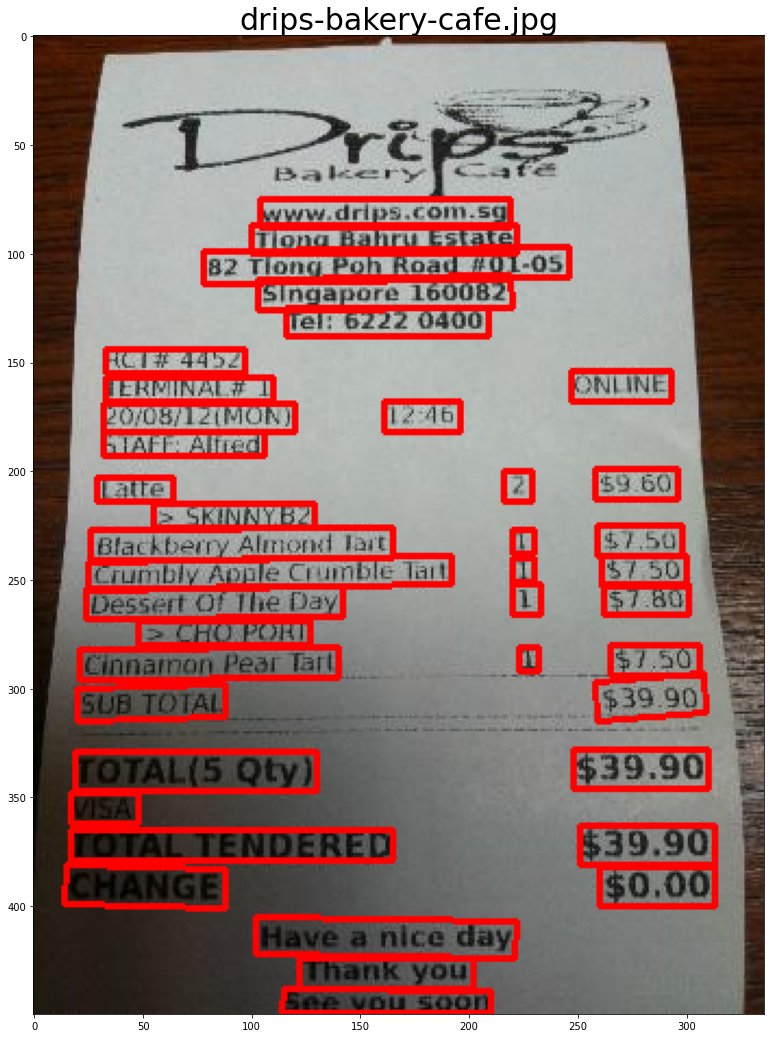

In [34]:
# Get results

# url = 'https://media-cdn.tripadvisor.com/media/photo-s/1b/6e/c6/7b/photo0jpg.jpg'
# url = 'https://cdn1.sg.orstatic.com/userphoto/photo/0/CQ/002IL4FB783618A0C585CAl.jpg'
# url = 'https://live.staticflickr.com/7156/6442003235_1e06faa9ed_z.jpg'
url = 'https://media-cdn.tripadvisor.com/media/photo-s/02/fd/b9/e9/drips-bakery-cafe.jpg'

if download_image(url):
    display_boxes_on_file(
        fn=os.path.basename(url),
        rect_boxes=False
    )

# Task 3

## Imports, models

In [25]:
import torch
from transformers import VisionEncoderDecoderModel, VisionEncoderDecoderConfig, DonutProcessor

Ensure cuda is available

In [26]:
print(torch.cuda.is_available())

True


Init DonutProcessor with [pretrained model](https://huggingface.co/unstructuredio/donut-base-sroie)

In [ ]:
processor = DonutProcessor.from_pretrained("unstructuredio/donut-base-sroie")
pretrained_model = VisionEncoderDecoderModel.from_pretrained("unstructuredio/donut-base-sroie")

device = "cuda" if torch.cuda.is_available() else "cpu"
pretrained_model.to(device)

Make a function to extract entities (address, company, date, total) from receipt using DonutProcessor

In [28]:
def make_entities_file(file_name):
    global pretrained_model, processor

    path_to_test_img = os.path.join(sroie_test_img_dir, file_name)
    image = Image.open(path_to_test_img).convert("RGB")

    task_prompt = f"<s>"
    pixel_values = processor(image, return_tensors="pt").pixel_values
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids

    # run inference
    outputs = pretrained_model.generate(
        pixel_values.to(device),
        decoder_input_ids=decoder_input_ids.to(device),
        max_length=pretrained_model.decoder.config.max_position_embeddings,
        early_stopping=True,
        pad_token_id=processor.tokenizer.pad_token_id,
        eos_token_id=processor.tokenizer.eos_token_id,
        use_cache=True,
        num_beams=1,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
    )

    # process output
    prediction = processor.batch_decode(outputs.sequences)[0]
    prediction = processor.token2json(prediction)
    prediction = dict(sorted(prediction.items()))

    for key in ['address', 'company', 'date', 'total']:
        if key not in prediction:
            prediction[key] = ''

    file_name_2 = file_name.split('.')[0] + '.txt'

    path_to_test_pred_file = os.path.join(sroie_test_pred_ent_dir, file_name_2)
    with open(path_to_test_pred_file, "w") as fp:
        json.dump(prediction, fp) 


## Batch predict

Extract entities files from test folder

In [ ]:
for file_name in tqdm(os.listdir(sroie_test_img_dir)):
    make_entities_file(file_name)

print('Done')

  0%|          | 0/347 [00:00<?, ?it/s]

Done


## Test metrics

Get final metrics for task 3

In [ ]:
def calculate_mean_Levenshtein_similarity(gt: dict, pred: dict, case_sensitive=False):
    assert len(gt) == len(pred)
    assert set(gt.keys()) == set(pred.keys())

    gt = [v for k, v in sorted(gt.items(), key=lambda item: item[0])]
    pred = [v for k, v in sorted(pred.items(), key=lambda item: item[0])]

    if case_sensitive:
        return sum([Levenshtein_ratio(gt_str, pred_str) for gt_str, pred_str in zip(gt, pred)]) / len(gt)
    else:
        return sum([Levenshtein_ratio(gt_str.lower(), pred_str.lower()) for gt_str, pred_str in zip(gt, pred)]) / len(gt)

def calc_metric_for_one_file(fn):

    with open(os.path.join(sroie_test_gt_ent_dir, fn)) as f:
        gt_entities = json.load(f)

    with open(os.path.join(sroie_test_pred_ent_dir, fn)) as f:
        pred_entitites = json.load(f)

    mean_entities_ratio = calculate_mean_Levenshtein_similarity(gt_entities, pred_entitites)
    # entities_lratios.append(mean_entities_ratio)

    return round(mean_entities_ratio, 4)

entities_lratios = list()
for fn in tqdm(os.listdir(sroie_test_img_dir)):
    metric = calc_metric_for_one_file(fn[:-4] + '.txt')
    entities_lratios.append(metric)

print(f'Mean entities Levenstein ratio: {round(sum(entities_lratios)/len(entities_lratios), 4)}')

  0%|          | 0/347 [00:00<?, ?it/s]

Mean entities Levenshtein ratio: 0.9177


## Demo on random receipt

Make function

In [29]:
def run_prediction(sample):
    global pretrained_model, processor

    task_prompt = f"<s>"
    
    pixel_values = processor(sample, return_tensors="pt").pixel_values
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids

    # run inference
    outputs = pretrained_model.generate(
        pixel_values.to(device),
        decoder_input_ids=decoder_input_ids.to(device),
        max_length=pretrained_model.decoder.config.max_position_embeddings,
        early_stopping=True,
        pad_token_id=processor.tokenizer.pad_token_id,
        eos_token_id=processor.tokenizer.eos_token_id,
        use_cache=True,
        num_beams=1,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
    )

    # process output
    prediction = processor.batch_decode(outputs.sequences)[0]
    prediction = processor.token2json(prediction)
    prediction = dict(sorted(prediction.items()))

    for key in ['address', 'company', 'date', 'total']:
        if key not in prediction:
            prediction[key] = ''

    matplotlib.rcParams['figure.figsize'] = 10, 8

    print(json.dumps(prediction, indent=2))

    fig, ax = matplotlib.pyplot.subplots()
    ax.set_title(fn, fontsize= 15)
    ax.imshow(sample);
    matplotlib.pyplot.show()

    # return prediction
    # return image

Get results with corresponding image. Feel free to change `url` to test any receipt from internet

{
  "address": "82 TLONG POH ROAD #01-05 SINGAPORE 160082",
  "company": "BAKERY",
  "date": "20/08/12",
  "total": "$39.90"
}


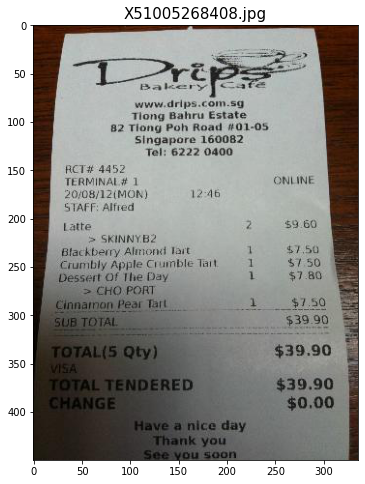

In [36]:
# File from internet
# url = 'https://media-cdn.tripadvisor.com/media/photo-s/1b/6e/c6/7b/photo0jpg.jpg'
# url = 'https://cdn1.sg.orstatic.com/userphoto/photo/0/CQ/002IL4FB783618A0C585CAl.jpg'
# url = 'https://live.staticflickr.com/7156/6442003235_1e06faa9ed_z.jpg'
url = 'https://media-cdn.tripadvisor.com/media/photo-s/02/fd/b9/e9/drips-bakery-cafe.jpg'

run_prediction(Image.open(requests.get(url, stream=True).raw).convert("RGB"))